# Uniform random number generator

Voor deze opdracht werd er gevraagd een Pseudo-Random Number Generator (PRNG) te bouwen.

Deze methode wordt gebruikt om pseudo willekeurige getallen te genereren. De methode herhaalt na een bepaalde tijd dezelfde set getallen, maar deze manier is snel, deterministisch en wordt gebruikt om een herhaalbare set van getallen te genereren.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import time
import math
import random as rd

Mijn eerste idee was om een random number generator te bouwen op basis van de tijd.
Deze generator zou op basis van de huidige tijd getallen teruggeven. Het idee hierachter is dat de generator de huidige tijd opvraagt, daarvan de laatste twee getallen wegknipt (van de nanoseconden (ongeveer)) en dan een tijd zou wachten om dit gehele proces opnieuw te starten.

Alhoewel dit (redelijk) gelukt is is deze generator niet pseudo willekeurig, omdat hij niet tot nauwelijks herhaalbaar is. Verder zou dit proces zeer lang kunnen duren, op basis van de hoeveelheid getallen die gegenereerd moeten worden.

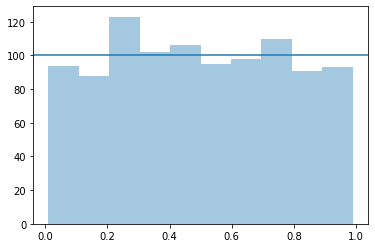

In [2]:
def uniform_gen_waiting_time_test(samples):
    """Random generator based on time"""
    result = []
    for x in range(samples):
        n = time.time()
        result.append(float(str(n)[-2:]) / 100)
        time.sleep(.0001)
    return result

x_samples = 1000
dist_test = uniform_gen_waiting_time_test(x_samples)

# plotting the results
sns.distplot(dist_test, bins=10, kde=False)
plt.axhline(x_samples // 10)

## Lagged Fibonacci Generator (LFG)

In het algemeen is de Fibonacci reeks als volgt gedefinieerd: 

$S_n = S_{n-1} + S_{n-2}$  

Hierbij is ieder element de som van de vorige twee elementen. Gebaseerd op dit herhalende gedrag kan de LFG als volgt worden geschreven:

$x_n = x_{n-j}\; O \;x_{n-k}\; (mod \;m)$

In deze formule geldt $0<j<k$ en de initiële condities moeten kloppen. In deze generator wordt het volgende element gecreeërd door de twee vorige elementen te combineren gebruikmakend van een algebraïsche operatie $O$.

In [3]:
class PseudoRandomGen(object):
    """
    implements a lagged Fibonacci generator (LFG)
    """
    def __init__(self, seed, opp: str="+", j: int=3, k: int=7, m: int=10):
        # check for requirements of j and k
        assert 0 < j < k
        
        # check the requirements of the seed
        self.seed = str(seed)
        assert len(self.seed) >= k
        
        if opp == "+":
            self.opp = lambda x, y : x + y
        elif opp == "-":
            self.opp = lambda x, y : x - y
        elif opp == "*":
            self.opp = lambda x, y : x * y
        else:
            raise Exception('operation is not supported')
            
        self.seed = np.array(list(map(int, self.seed)))
        self.j = j
        self.k = k
        self.m = m
    
    def gen_random(self):
        """"""
        new_int = self.opp(self.seed[self.j - 1], self.seed[self.k - 1]) % self.m
        self.seed = np.append(self.seed[1:], new_int)
        return new_int
    
    def gen_random_sample(self, n):
        """"""
        result = []
        for x in range(n):
            result.append(self.gen_random())
        return result

Wanneer we dit uitvoeren komen er de volgende resultaten uit.

In [4]:
rd_test = PseudoRandomGen(6421893, m=100)

for x in range(0, 5):
    print("{0} --> {1}".format(rd_test.seed, rd_test.gen_random()))

[6 4 2 1 8 9 3] --> 5
[4 2 1 8 9 3 5] --> 6
[2 1 8 9 3 5 6] --> 14
[ 1  8  9  3  5  6 14] --> 23
[ 8  9  3  5  6 14 23] --> 26


Om uit te testen in hoeverre deze resultaten uniform verdeeld zijn heb ik ervoor gekozen om voor meerdere sample sizes te kiezen en voor iedere sample size de resultaten in bins op te delen om deze hierna te plotten.

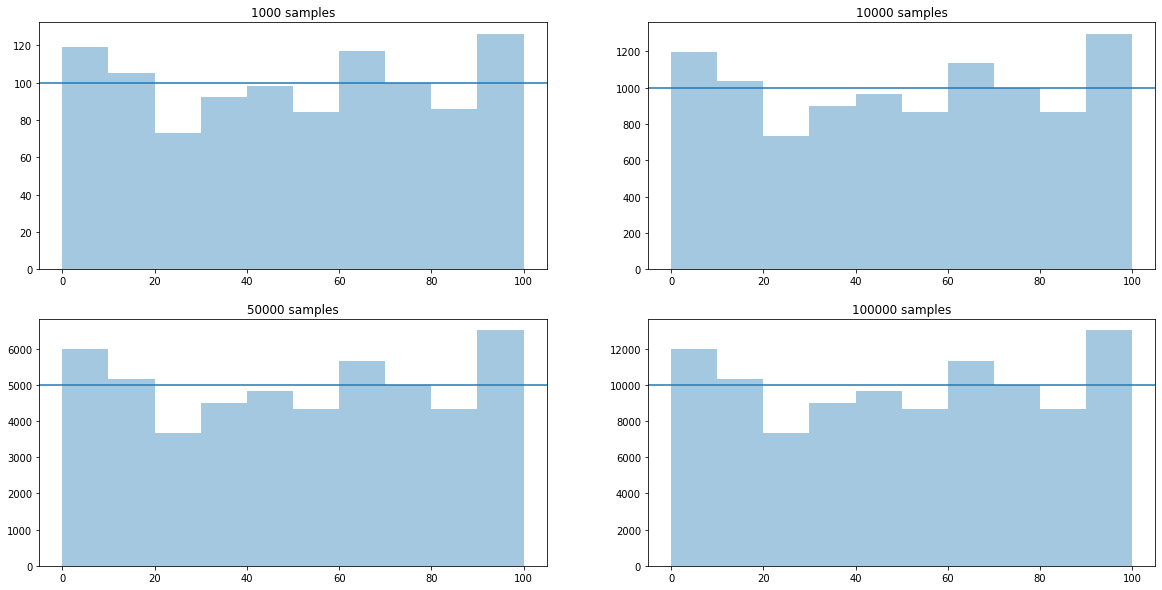

In [5]:
tests = [1000, 10000, 50000, 100000]
count = 0

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for x in [0, 1]:
    for y in [0, 1]:
        
        new_rd = PseudoRandomGen(6421893, m=101)

        dist = []
        for i in range(tests[count]):
            dist.append(new_rd.gen_random())

        sns.distplot(dist, bins=10, kde=False, ax=axs[x][y])
        axs[x][y].set_title("{0} samples".format(tests[count]))
        axs[x][y].axhline(tests[count] // 10)
        
        count += 1

Zoals in de grafieken te zien valt zijn alle plots vrijwel hetzelfde, de LFG heeft dan ook een terugkerend patroon. Verder valt te zien dat de LFG niet echt heel uniform verdeeld is.

## chi-square test
De chi-square test test of een reeks van pseudo willekeurige getallen tussen de 0 en 1 uniform verdeeld zijn.

In [6]:
from scipy.stats import chisquare

new_rd = PseudoRandomGen(6421893, m=101)
dist = np.array(new_rd.gen_random_sample(10000)) / 100

chisquare(dist)

Power_divergenceResult(statistic=1811.8865812897075, pvalue=1.0)

In [7]:
test_dist = np.random.random_sample(10000)
chisquare(test_dist)

Power_divergenceResult(statistic=1644.1260645598977, pvalue=1.0)

Zoals hierboven te zien is hebben beide tests een P-waarde van 1. 

## Pi benaderen d.m.v. kansverdeling

In dit stuk zal ik proberen om mijn eerder gebouwde random number generator te gebruiken om pi te benaderen.

Om pi te benaderen gaan we uit van een cirkel met een radius van 1. Om te testen of een punt zich in de cirkel bevindt maken we gebruik van de stelling van pythagoras. Hiervoor maken we gebruik van de formule:

$\sqrt{a^2 + b^2} <= 1$ 

Wanneer deze formule klopt zal het punt zich binnen de cirkel bevinden, anders bevindt het punt zich buiten de cirkel. Om het qua berekening makkelijker te maken maken we gebruik van een kwart van de cirkel, hierdoor kunnen we random getallen tussen de 0 en de 1 gebruiken.

Aangezien we nu maar een kwart van de cirkel gebruiken om erachter te komen of de punten binnen of buiten de cirkel vallen moet de hoeveelheid punten die erbinnen vallen nog eens met 4 vermenigvuldigd worden. De formule die we uiteindelijk gebruiken om pi te berekenen is als volgt:

$\pi = \frac{4 \; \cdot \; inside}{n}$

In [8]:
def approach_pi(n, seed, use_own=True):
    
    if use_own:
        x_rand = PseudoRandomGen(seed, m=101)
        x = np.array(x_rand.gen_random_sample(n)) / 100
    
        y_rand = PseudoRandomGen(seed + 42, m=101)
        y = np.array(y_rand.gen_random_sample(n)) / 100
    else:
        x = np.random.random_sample(n)
        y = np.random.random_sample(n)
        
    inside = 0
    for i in range(n):
        if math.sqrt((x[i] ** 2) + (y[i] ** 2)) <= 1:
            inside += 1
    
    return 4 * inside/n
    

Wanneer we dan uiteindelijk de functie laten draaien komen de volgende resultaten eruit.

In [9]:
seed = 6421893

print('{:<8} {:<8} {:<8}'.format('n', 'pi', 'error'))
for x in [1, 10, 100, 1000, 10000, 100000]:
    pred_pi = approach_pi(x, seed)
    error = math.pi - pred_pi
    print('{:<8} {:<8} {:<8}'.format(x, pred_pi, error))

n        pi       error   
1        4.0      -0.8584073464102069
10       3.2      -0.05840734641020706
100      3.2      -0.05840734641020706
1000     3.176    -0.03440734641020704
10000    3.1736   -0.03200734641020686
100000   3.17336  -0.031767346410207065


Zoals in de resultaten te zien valt is de proef helaas niet al te accuraat.

In [10]:
seed = 6421893

print('{:<8} {:<8} {:<8}'.format('n', 'pi', 'error'))
for x in [1, 10, 100, 1000, 10000, 100000]:
    pred_pi = approach_pi(x, seed, use_own=False)
    error = math.pi - pred_pi
    print('{:<8} {:<8} {:<8}'.format(x, pred_pi, error))

n        pi       error   
1        4.0      -0.8584073464102069
10       3.6      -0.458407346410207
100      3.12     0.02159265358979301
1000     3.04     0.10159265358979308
10000    3.1268   0.014792653589793314
100000   3.14244  -0.0008473464102070061
